# Comparative Analysis of Chemical Composition in Red and White Wines: A Study on Volatile Acidity

In [1]:
# Required libraries
library(tidyverse)
install.packages("infer")
library(infer)
library(repr)
library(dplyr)
library(readr)
options(repr.plot.width=5, repr.plot.height=5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [2]:
# Reading in the data
url <- "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"

# Define the local file name for the downloaded ZIP file
zip_file <- "data/wine_quality.zip"

# Download the ZIP file from the URL
download.file(url, destfile = zip_file)

# Unzip the downloaded file
unzip(zip_file, exdir = "data")

## Introduction

The goal of the project is to explore the average level of Volatile Acidity, Total Sulfur Dioxide and Chlorides in Red and White wine. The dataset, [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality), is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).

The dataset includes 13 attributes describing 

- ```Fixed Acidity```
- ```Volatile Acidity```
- ```Citric Acid```
- ```Residual Sugar```
- ```Chlorides```
- ```Free Sulfur Dioxide```
- ```Total Sulfur Dioxide```
- ```Density```
- ```pH```
- ```sulphates```
- ```alcohol```
- ```quality```

Research Question
<hr></hr>
How do the levels of <b>volatile acidity</b> differ between <b>red</b> and <b>white wines</b>, and are there statistically significant variations in these chemical components between the two wine types?

Our attribute of interest for this project is:

- ```Volatile Acidity```: Volatile acidity in the context of wine refers to the presence of volatile acids, primarily acetic acid.  It is a key factor in wine quality and can impact the wine's flavor and aroma.

To conduct research, we will be exploring the average levels (location parameter) of <b>volatile acidity</b> for each of the wines as well as standard deviation (scale parameter).

Volatile acidity plays a pivotal role in the winemaking process, and exhibits substantial variations across different wines. A study conducted by Babincev and Jović in 2021 delves into the chemical composition of white and red wines, revealing that white wine tends to have higher acidity levels compared to red wine. This finding underscores the importance and relevance of further investigation of volatile acidity.

## Methods and Results

<b> Overview: </b> We will be conducting a hypothesis test at the 5% significance level via permutation, in order to examine the difference in mean volatile acidity between red and white wine. Our null hypothesis is $H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$ , and our alternative hypothesis is $H_{a}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} \neq 0$. We will also be creating a confidence interval*** 

### Wrangling the data

First, we read in the red wine and white wine data and check to see if there are any missing values. We also add a column to 
each dataset to indicate the type of wine. Seeing that there are no missing values, there is no need to remove any rows and we proceed by combining the data into one data frame.

In [3]:
# Read in the red and white wine data

wine_red_data <- read_delim("data/winequality-red.csv", delim = ";", show_col_types = FALSE) |>
                    mutate(type = "red")
wine_white_data <- read_delim("data/winequality-white.csv", delim = ";", show_col_types = FALSE)|>
                    mutate(type = "white")
# Check if we have missing values
sum(is.na(wine_white_data))
sum(is.na(wine_red_data)) 

[1] 0

[1] 0

In [4]:
# Combining the red/white wine data and adding proper column names to the dataframe

wine_data <- rbind(wine_red_data, wine_white_data)
colnames(wine_data) <- c("fixed.acidity","volatile.acidity","citric.acid","residual.sugar",
                         "chlorides","free.sulfur.dioxide","total.sulfur.dioxide","density",
                         "pH","sulphates","alcohol","quality","type")
head(wine_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


Now that we have combined the two datasets, we drop all the unnecessary columns to isolate our desired attribute (volatile acidity) and the wine type.

In [12]:
wine_data_specific <- wine_data %>%
                        select(volatile.acidity, type)
head(wine_data_specific)

volatile.acidity,type
<dbl>,<chr>
0.70,red
0.88,red
0.76,red
0.28,red
0.70,red
0.66,red


In [13]:
dim(wine_data_specific)

[1] 6497    2

# Preliminary Analysis #

We begin by conducting some preliminary analysis to explore our data. Here we plot the sample distribution for our attribute of interest, volatile acidity, using colour to differentiate between the red and white wine observations.

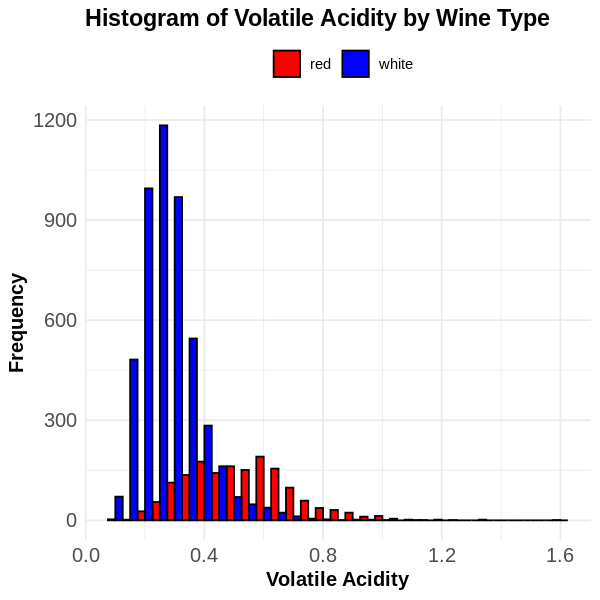

In [14]:
# Histogram of volatile acidity against the respective wine type

ggplot(wine_data_specific, aes(x = volatile.acidity, fill = type)) +
  geom_histogram(binwidth = 0.05, position = "dodge", color = "black") +
  labs(title = paste("Histogram of Volatile Acidity by Wine Type"), x = "Volatile Acidity", y = "Frequency") +
  scale_fill_manual(values = c("red" = "red", "white" = "blue")) +
  theme_minimal() +
  theme(legend.title = element_blank(),
        legend.position = "top",  # Change the legend position
        plot.title = element_text(size = 14, face = "bold"),  # Title style
        axis.text = element_text(size = 12),  # Axis label text size
        axis.title = element_text(size = 12, face = "bold"))

The histogram clearly illustrates a contrast in the mean concentration of volatile acids between red and white wines in our sample. White wine appears to have a much lower mean concentration than red wine, hence the value of conducting a hypothesis test. 

We also produce a boxplot to more easily see the difference in distribution of volatile acid concentration between the 2 wine types. As can be seen below, each type of wine exhibits a unique distribution pattern, emphasizing the disparity observed in their chemical composition.

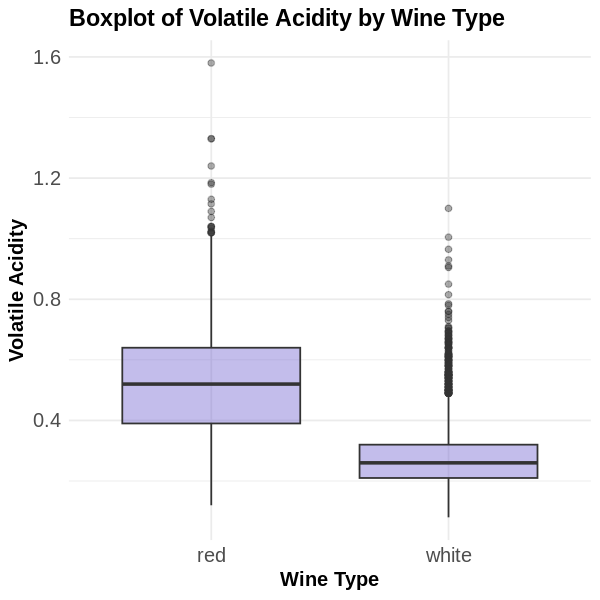

In [15]:
ggplot(wine_data_specific, aes(x = type, y = volatile.acidity)) +
      geom_boxplot(fill = "slateblue", alpha = 0.4) +
      labs(title = paste("Boxplot of Volatile Acidity by Wine Type", sep = " "), x = "Wine Type", y = "Volatile Acidity") +
      theme_minimal() +
      theme(legend.title = element_blank(),
            legend.position = "top",  # Change the legend position
            plot.title = element_text(size = 14, face = "bold"),  # Title style
            axis.text = element_text(size = 12),  # Axis label text size
            axis.title = element_text(size = 12, face = "bold"))

In [16]:
dim(wine_data_specific)

[1] 6497    2

## Hypothesis Test Via Permutation

Now that have taken a closer look at the data we are working with, we are ready to begin our hypothesis test. We start by calculating the observed test statistic for our sample. That is, the observed difference in volatile acidity between red and white wine in our dataset.

In [17]:
set.seed(42) # Setting the seed for reproducible workflow

wine_sample <- wine_data_specific
head(wine_sample)

volatile.acidity,type
<dbl>,<chr>
0.70,red
0.88,red
0.76,red
0.28,red
0.70,red
0.66,red


In [19]:
obs_diff_in_means <- wine_sample %>%
    specify(volatile.acidity ~ type) %>%
    calculate(stat = "diff in means", order = c("red", "white"))
obs_diff_in_means

stat
<dbl>
0.2495794


Next, we create the null distribution, based on our null hypothesis shown below. To achieve this, we specify our formula and generate 1000 permutation replicates using the infer package. We use the permutation method because our test statistic is the difference in means, where our null hypothesis is equal concentrations of volatile acids between red and white wine. We calculate the difference in means for each replicate by subtracting the mean of white wine from the mean of red wine.

$H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$.

In [22]:
null_dist <- wine_sample %>%
    specify(volatile.acidity ~ type) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type="permute") %>%
    calculate(stat = "diff in means", order = c("red", "white"))
head(null_dist)

replicate,stat
<int>,<dbl>
1,0.009626221
2,-0.001796763
3,0.006668855
4,0.010795895
5,0.006129643
6,-0.004111224


After obtaining the null distribution, we can visualize it and shade in the p-value based on the observed test statistic we calculated earlier.

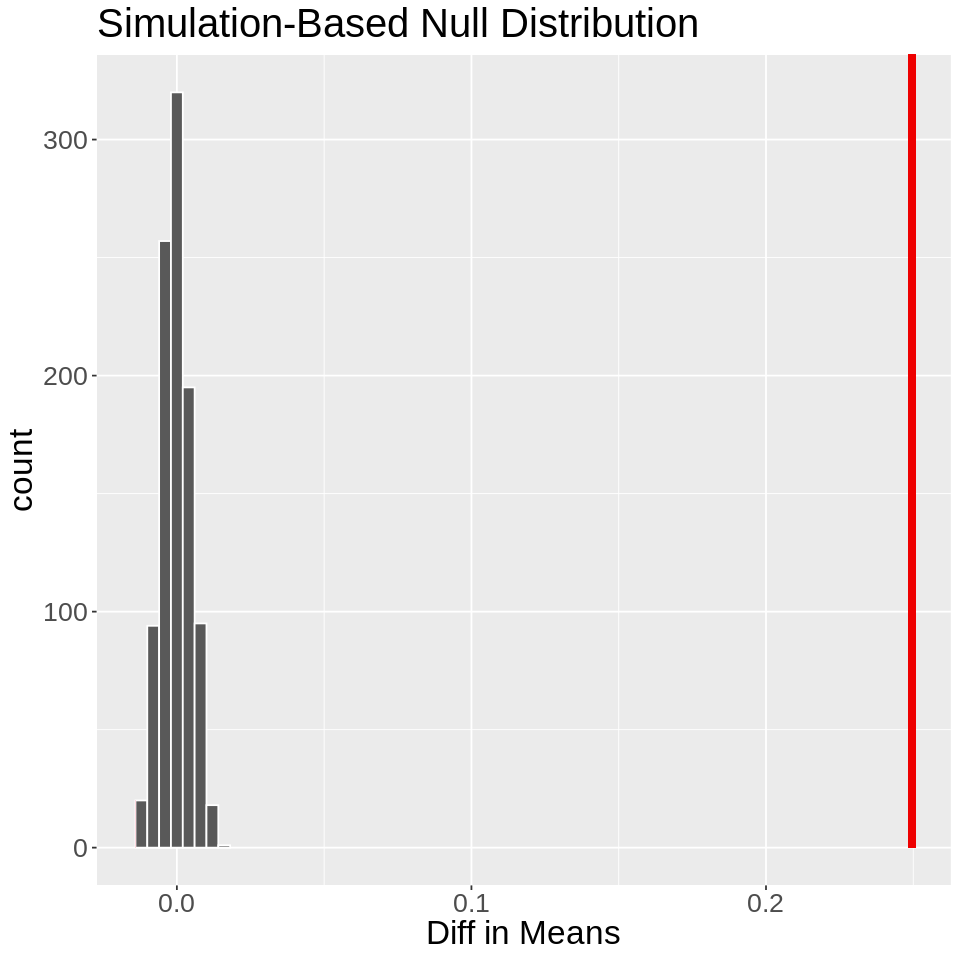

In [25]:
options(repr.plot.width=8, repr.plot.height=8)
visualize(null_dist, bins = 8) + 
    shade_p_value(obs_stat=obs_diff_in_means, direction = "two_sided") + theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Diff in Means")

In [ ]:
p_val <- null_dist %>%
    get_p_value(obs_stat = obs_diff_in_means, direction = "two-sided")
p_val

In [24]:
wine_ci <- wine_sample %>%
    specify(volatile.acidity ~ type) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("red", "white")) %>%
    get_ci()
wine_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.24029,0.25919


### Calculating CI with CLT

In [ ]:
red <- wine_sample %>%
    filter(type == "red") %>%
    pull(volatile.acidity)

white <- wine_sample %>%
    filter(type == "white") %>%
    pull(volatile.acidity)

wine_diff_means_ci <- 
    tibble(
        lower_ci = mean(red) - mean(white) - qnorm(0.975) * sqrt(var(red)/length(red) + var(white)/length(white)),
        upper_ci = mean(red) - mean(white) + qnorm(0.975) * sqrt(var(red)/length(red) + var(white)/length(white))
    )
wine_diff_means_ci

## Discussion

## References

- Babincev, L.M., Jović, S. Determination of the amount of volatile acids in oxidized wines and neutralization of these by using chemical reagents and biological materials. Biomass Conv. Bioref. 13, 4717–4725 (2023). https://doi.org/10.1007/s13399-021-01339-7
- Kelly M. Volatile Acidity in Wine PennState Extension https://extension.psu.edu/volatile-acidity-in-wine